### Notebook to examine salary information of law professors in Ontario, using Sunshine List

Must first run scrape_bios.ipynb, then parse_bios.ipynb.

### Setup

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np

### Load and merge datasets

In [99]:
# Load sunshine list data
#request = requests.get('https://www.ontario.ca/public-sector-salary-disclosure/pssd-assets/files/2021/tbs-pssd-compendium-salary-disclosed-2021-en-utf-8-2023-01-05.json')
#request = requests.get('https://www.ontario.ca/public-sector-salary-disclosure/pssd-assets/files/2022/tbs-pssd-compendium-salary-disclosed-2022-en-utf-8-2023-03-24.json')
request = requests.get('https://www.ontario.ca/public-sector-salary-disclosure/pssd-assets/files/2023/tbs-pssd-compendium-salary-disclosed-2023-en-utf-8-2024-03-28.json')
df_sunshine = pd.read_json(request.text)

# change 'Walker Cm" to "Walker" in last name
df_sunshine.loc[df_sunshine['Last Name'].str.contains('Walker Cm'), 'Last Name'] = 'walker'

# change "Jean-Christo" to "Jean-Christophe" in first name
df_sunshine.loc[df_sunshine['First Name'].str.contains('Jean-Christo', na=False), 'First Name'] = 'Jean-Christophe'

# simplify first and last names for matching
df_sunshine['last_simple'] = df_sunshine['Last Name'].str.replace('[.,]', ' ', regex=True).str.strip()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.replace('\’', ' ', regex=True).str.strip()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.replace('\'', ' ').str.strip()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.split(' ').str[-1].str.strip().str.lower()
df_sunshine['last_simple'] = df_sunshine['last_simple'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Remove single quotes of various formats from Employer
df_sunshine['first_simple'] = df_sunshine['First Name'].str.replace('[.,]', ' ', regex=True).str.strip()
df_sunshine['first_simple'] = df_sunshine['first_simple'].str.split(' ').str[0].str.strip().str.lower()
df_sunshine['first_simple'] = df_sunshine['first_simple'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# Remove single quotes of various formats from Employer
df_sunshine['Employer'] = df_sunshine['Employer'].str.replace('\’', '', regex=True).str.strip()
df_sunshine

# if Employer = "Queen's University" make it "Queens University" to match prior years
df_sunshine['Employer'] = df_sunshine['Employer'].str.replace("Queen's University", "Queens University", regex=False)
# same for "University Of Ottawa / Université D'Ottawa" to "University Of Ottawa"
df_sunshine['Employer'] = df_sunshine['Employer'].str.replace("University Of Ottawa / Université D'Ottawa", "University Of Ottawa", regex=False)




In [100]:
# Load faculty bios from json
df = pd.read_json('data/all_bios_parsed.json')

# Clean data for matching with sunshine list

# rename universities to match sunshine list
universities = {
    'osgoode': 'York University',
    'u_toronto': 'University Of Toronto',
    'tmu': 'Toronto Metropolitan University',
    'queens': 'Queens University',
    'western': 'University Of Western Ontario',
    'windsor': 'University Of Windsor',
    'uottawa-common': 'University Of Ottawa',
    'uottawa-civil': 'University Of Ottawa',
    'lakehead': 'Lakehead University',

    }
df['university'] = df['faculty'].apply(lambda x: universities[x])

# simplify first and last names for matching
df['name_simple'] = df['name'].str.replace('[.,]', ' ', regex=True).str.strip()
df['name_simple'] = df['name_simple'].str.replace('’', ' ', regex = True).str.strip()
df['name_simple'] = df['name_simple'].str.replace('\'', ' ').str.strip()
df['last_name'] = df['name_simple'].apply(lambda x: x.split(' ')[-1]).str.strip().str.lower()
df['first_name'] = df['name_simple'].apply(lambda x: x.split(' ')[0]).str.strip().str.lower()
df['last_name'] = df['last_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['first_name'] = df['first_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Manual changes do to variations in names
df.loc[df['name'] == 'Jonathon Penney', 'first_name'] = 'jon'
df.loc[df['name'] == 'Jim Phillips', 'first_name'] = 'james'
df.loc[df['name'] == 'Timothy J. Bartkiw', 'first_name'] = 'tim'
df.loc[df['name'] == 'Sharry Aiken', 'first_name'] = 'sharryn'
df.loc[df['name'] == 'Will Kymlicka', 'first_name'] = 'william'
df.loc[df['name'] == 'Chi Carmody', 'first_name'] = 'chios'
df.loc[df['name'] == 'Akis Psygkas', 'first_name'] = 'athanasios'
df.loc[df['name'] == 'Jeff Berryman', 'first_name'] = 'jeffrey'
df.loc[df['name'] == 'Patricia Galvão Ferreira', 'last_name'] = 'galvao-ferreira'
df.loc[df['name'] == 'Tess Sheldon', 'first_name'] = 'c'
df.loc[df['name'] == 'Yin-Yuan Chen', 'first_name'] = 'yin'
df.loc[df['name'] == 'P M Vasudev', 'first_name'] = 'palladam'
df.loc[df['name'] == 'Marel Katsivela', 'first_name'] = 'maria'
df.loc[df['name'] == 'John Packer', 'first_name'] = 'frederick'
df.loc[df['name'] == 'Muriel Paradelle', 'first_name'] = 'murielle'
df.loc[df['name'] == 'Jean-Christophe Bédard-Rubin', 'last_name'] = 'bedard-rubin'
df.loc[df['name'] == 'Ed Béchard-Torres', 'last_name'] = 'bechard-torres'
df.loc[df['name'] == 'Ed Béchard-Torres', 'first_name'] = 'edward'
df.loc[df['name'] == 'Chris Fredette', 'first_name'] = 'christopher'

print(df.university.value_counts())

#df


university
University Of Ottawa               109
York University                     61
University Of Toronto               61
Queens University                   39
University Of Western Ontario       36
University Of Windsor               33
Toronto Metropolitan University     21
Lakehead University                 13
Name: count, dtype: int64


### Merge datasets

In [101]:
# Merge df_sunshine and df using last_name, first_name and university from df, and Employer, Last Name and First Name from df_sunshine

df_merged = df.merge(df_sunshine, left_on=['last_name', 'first_name', 'university'], right_on=['last_simple', 'first_simple', 'Employer'])

# rename university values
universities = {
    'University Of Ottawa':'Ottawa',
    'York University': 'Osgoode',
    'University Of Toronto': 'Toronto',
    'Queens University': 'Queens',
    'University Of Western Ontario':'Western',
    'University Of Windsor':'Windsor',
    'Toronto Metropolitan University': 'Lincoln Alexander',
    'Lakehead University': 'Lakehead'
    }

df_merged['university'] = df_merged['university'].apply(lambda x: universities[x])

# change column 'Job Title' to 'title_sunshine'
try:
    df_merged = df_merged.rename(columns={'Job Title': 'Title'})
except:
    pass

try:
    df_merged = df_merged.rename(columns={'JobTitle': 'Title'})
except:
    pass

# keep only needed columns
df_merged = df_merged[['name', 'university', 'faculty', 'href', 'bio', 'extracted_research_areas', 'pronouns', 'Title', 'Salary' ]]

# Remove uottawa-civil
df_merged = df_merged[df_merged['faculty'] != 'uottawa-civil']

print(df_merged.university.value_counts())

#print number in df but not in df_merged
print()
print('Num in df but not in df_merged:')
print(len(df) - len(df_merged))
print()
df_merged


university
Ottawa               67
Osgoode              57
Toronto              54
Queens               35
Western              35
Windsor              28
Lincoln Alexander    19
Lakehead             11
Name: count, dtype: int64

Num in df but not in df_merged:
67



,name,university,faculty,href,bio,extracted_research_areas,pronouns,Title,Salary
0,Rabiat Akande,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,"[Legal History, Law and Religion, Constitution...",she/her,Assistant Professor,132222.90
1,Saptarishi Bandopadhyay,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,"[Climate Change, Environmental Law, Food Law, ...",other,Associate Professor,167908.68
2,Stephanie Ben-Ishai,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,"[Banking Law, Bankruptcy and Insolvency, Comme...",she/her,Professor,251672.98
3,Benjamin L. Berger,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,"[Constitutional Law, Criminal Law, Evidence, L...",he/him,Professor,229776.80
4,Kate Glover Berger,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Kate Glover Berger joined the facult...,"[Administrative Law, Constitutional Law, Publi...",she/her,Associate Professor,150403.68
...,...,...,...,...,...,...,...,...,...
301,Darren O'Toole,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,"Professor O’Toole teaches Aboriginal Law, Indi...","[Aboriginal Law, Indigenous Law, Legal Philoso...",he/him,Professeure agrégée ou professeur agrégé / Ass...,146117.28
302,Alain Roussy,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,Alain Roussy is an associate professor in the ...,"[Legal Ethics, Professional Responsibility]",he/him,Professeure agrégée ou professeur agrégé / Ass...,163455.96
303,Teresa Scassa,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,Dr. Teresa Scassa is the Canada Research Chair...,"[Intellectual Property, Law and Technology, Pr...",she/her,Chaire de recherche du Canada - Professeure ou...,206331.15
304,Stéphane Sérafin,Ottawa,uottawa-common,https://www.uottawa.ca/faculty-law/common-law/...,Stéphane Sérafin is a graduate of the Programm...,"[Aboriginal Law, Civil Litigation, Commercial ...",he/him,Professeure adjointe ou professeur adjoint / A...,117953.76


In [102]:
# Show professors in df but not df_merged
df_missing = df[~df['name'].isin(df_merged['name'])]
df_missing

,faculty,name,title,email,href,bio,listed_research_areas,extracted_research_areas,pronouns,university,name_simple,last_name,first_name
15,osgoode,Signa A. Daum Shanks,Associate Professor,sdaumshanks@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Signa A. Daum Shanks started at Osgoode in 201...,"[Law and Economics, indigenous Governance, L...","[Law and Economics, Indigenous Law, Legal Hist...",she/her,York University,Signa A Daum Shanks,shanks,signa
37,osgoode,Jennifer Nedelsky,Professor,jnedelsky@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Jennifer Nedelsky joined Osgoode in ...,None,"[Feminist Legal Theory, Legal Theory, Constitu...",she/her,York University,Jennifer Nedelsky,nedelsky,jennifer
38,osgoode,Obiora Chinedu Okafor,Professor & York Research Chair in Internation...,ookafor@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Obiora Chinedu Okafor is the Inaugur...,"[international Law, international Human Right...","[Human Rights Law, Immigration and Refugee Law...",he/him,York University,Obiora Chinedu Okafor,okafor,obiora
56,osgoode,Estair Van Wagner,Associate Professor,evanwagner@osgoode.yorku.ca,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Estair Van Wagner researches and tea...,None,"[Environmental Law, Natural Resources Law, Pro...",she/her,York University,Estair Van Wagner,wagner,estair
63,u_toronto,Anita Anand,None,website.law@utoronto.ca,https://www.law.utoronto.ca/faculty-staff/full...,J.R. Kimber Chair in Investor Protection and C...,"[Business Corporations, Business Law, Econom...","[Corporate Governance, Law and Economics, Secu...",she/her,University Of Toronto,Anita Anand,anand,anita
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,uottawa-civil,Jennifer Quaid,Professeure agrégée et vice-doyenne à la reche...,Jennifer.Quaid@uottawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,Jennifer Quaid est professeure agrégée et vice...,None,"[Antitrust Law, Competition Law, Corporate Gov...",other,University Of Ottawa,Jennifer Quaid,quaid,jennifer
369,uottawa-civil,David Robitaille,Vice-doyen aux études et professeur titulaire,david.robitaille@uottawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,David Robitaille est professeur titulaire à la...,None,"[Administrative Law, Constitutional Law, Envir...",other,University Of Ottawa,David Robitaille,robitaille,david
370,uottawa-civil,Terry Skolnik,Professeur agrégé,tskolnik@uottawa.ca,https://uniweb.uottawa.ca/members/4305/profile,Terry Skolnik is an associate professor (tenur...,None,"[Criminal Law, Criminal Procedure, Property, L...",he/him,University Of Ottawa,Terry Skolnik,skolnik,terry
371,uottawa-civil,Marie-Eve Sylvestre,"Doyenne, professeure titulaire",Marie-Eve.Sylvestre@uottawa.ca,https://www.uottawa.ca/faculte-droit/droit-civ...,Marie-Eve Sylvestre est doyenne et professeure...,None,"[Criminal Law, Anti-Discrimination, Poverty La...",other,University Of Ottawa,Marie-Eve Sylvestre,sylvestre,marie-eve


In [103]:
# show counts of university in df_missing
print(df_missing.university.value_counts())

# U Ottawa not reliable b/c of the way U Ottawa civil law website works

university
University Of Ottawa               42
University Of Toronto               7
University Of Windsor               5
York University                     4
Queens University                   4
Toronto Metropolitan University     2
Lakehead University                 2
University Of Western Ontario       1
Name: count, dtype: int64


In [104]:
#iterate through df_missing and print name
for index, row in df_missing.iterrows():
    print(row['name']+' -->'+row['university'])

    

Signa A. Daum Shanks -->York University
Jennifer Nedelsky -->York University
Obiora Chinedu Okafor -->York University
Estair Van Wagner -->York University
Anita Anand -->University Of Toronto
Vincent Chiao -->University Of Toronto
Kamari Clarke -->University Of Toronto
Nathalie Des Rosiers -->University Of Toronto
Sida Liu -->University Of Toronto
Mariana Valverde -->University Of Toronto
Arnold Weinrib -->University Of Toronto
Jake Effoduh -->Toronto Metropolitan University
Priscylla Joca -->Toronto Metropolitan University
Oluwatobiloba Moody -->Queens University
Bruce Pardy -->Queens University
Patricia Peppin -->Queens University
Don Stuart -->Queens University
Shimelis Kene -->University Of Western Ontario
Daniel Del Gobbo -->University Of Windsor
Sylvia Mcadam -->University Of Windsor
Claire Mummé -->University Of Windsor
Jillian Rogin -->University Of Windsor
Valarie Waboose -->University Of Windsor
Daniel Cox -->Lakehead University
Robin Whitehead -->Lakehead University
Jamie Be

In [105]:
# Save merged data to json
df_merged.to_json('data/ontario_bios_w_salaries.json')

### Analysis of salaries of Toronto law professors

In [106]:
# Read merged data
df_merged = pd.read_json('data/ontario_bios_w_salaries.json')

# restrict to Toronto faculty
toronto_faculties = ['Toronto', 'Osgoode', 'Lincoln Alexander']
df_merged = df_merged[df_merged['university'].isin(toronto_faculties)]
df_merged

,name,university,faculty,href,bio,extracted_research_areas,pronouns,Title,Salary
0,Rabiat Akande,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Rabiat Akande works in the fields of...,"[Legal History, Law and Religion, Constitution...",she/her,Assistant Professor,132222.90
1,Saptarishi Bandopadhyay,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,I am an Associate Professor at Osgoode Hall La...,"[Climate Change, Environmental Law, Food Law, ...",other,Associate Professor,167908.68
2,Stephanie Ben-Ishai,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Stephanie Ben-Ishai is a Distinguish...,"[Banking Law, Bankruptcy and Insolvency, Comme...",she/her,Professor,251672.98
3,Benjamin L. Berger,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Benjamin L. Berger is Professor and ...,"[Constitutional Law, Criminal Law, Evidence, L...",he/him,Professor,229776.80
4,Kate Glover Berger,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Kate Glover Berger joined the facult...,"[Administrative Law, Constitutional Law, Publi...",she/her,Associate Professor,150403.68
...,...,...,...,...,...,...,...,...,...
125,Pnina Alon-Shenker,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Pnina Alon-Shenker is an associate professor i...,"[Employment Law, Labour Law, Human Rights Law,...",she/her,Associate Professor,199005.46
126,Timothy J. Bartkiw,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Timothy J. Bartkiw is an associate professor i...,"[Employment Law, Labour Law, Comparative Law]",he/him,Associate Professor,212942.60
127,Gil Lan,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Gil Lan is an associate professor in the Linco...,"[Comparative Law, Corporate Governance, Intern...",he/him,Associate Professor,201153.85
128,Alexandra Orlova,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Alexandra Orlova received her PhD in law from ...,"[Criminal Law, International Criminal Law, Hum...",she/her,Professor,205203.97


In [107]:
# get average Salary for each university in df_merged
print ('Mean Salary by University')
print(df_merged.groupby('university')['Salary'].mean())
print()
print ('Median Salary by University')
print(df_merged.groupby('university')['Salary'].median())
print()
print ('-------------------------')
print()


# create new df with only pronouns and salary, and print value counts
df_pronouns = df_merged.copy()
print ('Pronouns used in bios')
print(df_pronouns.value_counts('pronouns'))
print()
print ('-------------------------')
print()

# Remove 'other' because this means no pronouns used in bio (e.g. first person or bio missing)
df_pronouns = df_pronouns[df_pronouns['pronouns'] != 'other']

# Note: No they/them pronouns used in any bios

# get mean and median salary for each pronoun
print('Mean Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].mean())
print()
print ('Median Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].median())
print()
print ('-------------------------')
print()

# get median salary for each pronoun, per university 
print('Mean Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].mean())
print()
print('Median Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].median())




Mean Salary by University
university
Lincoln Alexander    173324.840526
Osgoode              216569.878947
Toronto              275472.058704
Name: Salary, dtype: float64

Median Salary by University
university
Lincoln Alexander    143487.88
Osgoode              212241.60
Toronto              263314.47
Name: Salary, dtype: float64

-------------------------

Pronouns used in bios
pronouns
he/him     67
she/her    62
other       1
Name: count, dtype: int64

-------------------------

Mean Salary by Pronouns
pronouns
he/him     242042.342537
she/her    227877.429194
Name: Salary, dtype: float64

Median Salary by Pronouns
pronouns
he/him     229776.80
she/her    232926.66
Name: Salary, dtype: float64

-------------------------

Mean Salary by Pronouns and University
university         pronouns
Lincoln Alexander  he/him      159336.886667
                   she/her     185913.999000
Osgoode            he/him      219979.770000
                   she/her     215667.870000
Toronto           

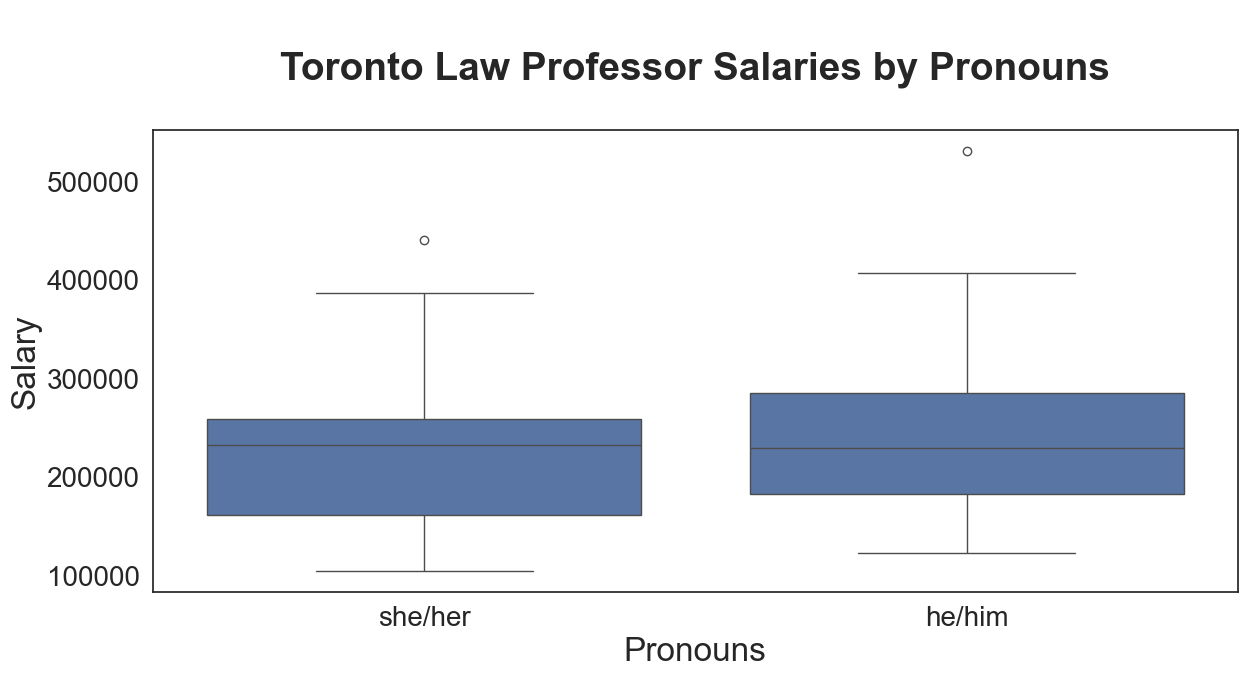

In [108]:
# graph the distribution of salaries for each pronoun
sns.set_palette('husl')
sns.set_theme(style="white")
ax = sns.boxplot(x="pronouns", y="Salary", data=df_pronouns)
ax.set_title('\nToronto Law Professor Salaries by Pronouns\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Pronouns', fontsize=24)
ax.set_ylabel('Salary', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(14, 6)
plt.show()

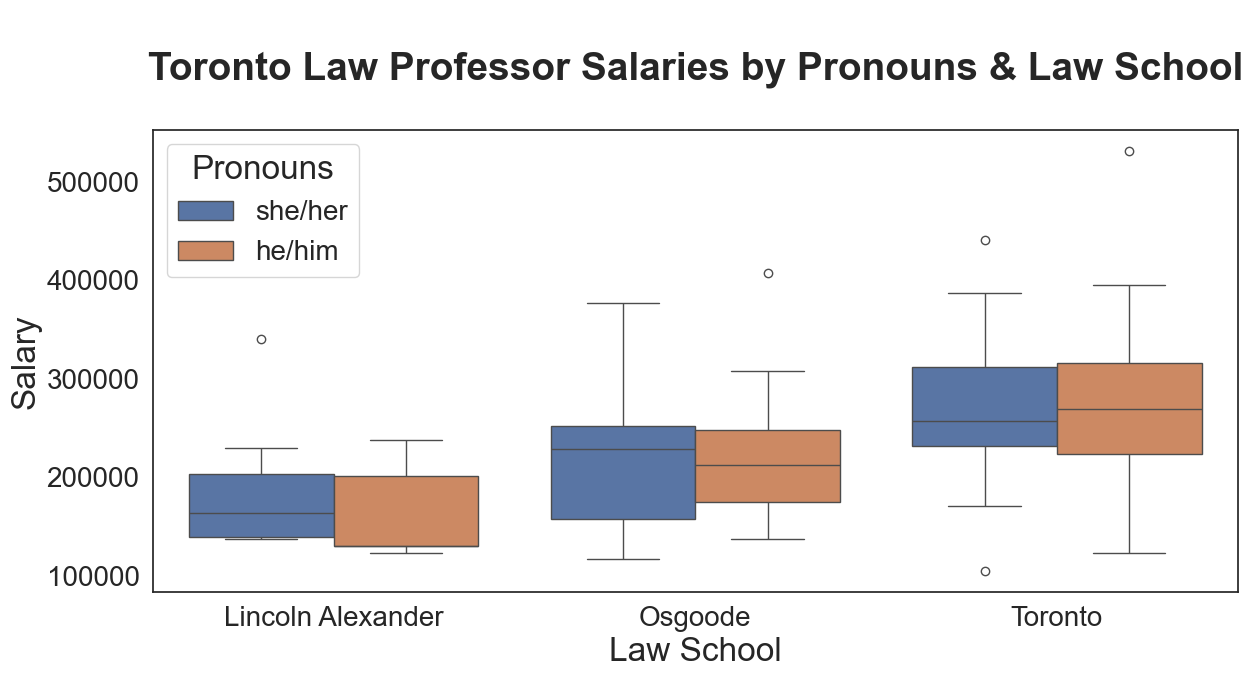

In [109]:
# graph the distribution of salaries for each pronoun, broken down by university
sns.set_theme(style="white")
university_order = df_pronouns['university'].sort_values().unique()
ax = sns.boxplot(x="university", y="Salary", hue="pronouns", data=df_pronouns, order=university_order)
ax.set_title('\nToronto Law Professor Salaries by Pronouns & Law School\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Law School', fontsize=24)
ax.set_ylabel('Salary', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(14, 6)
ax.legend(title='Pronouns', fontsize=20, title_fontsize=24)
plt.show()

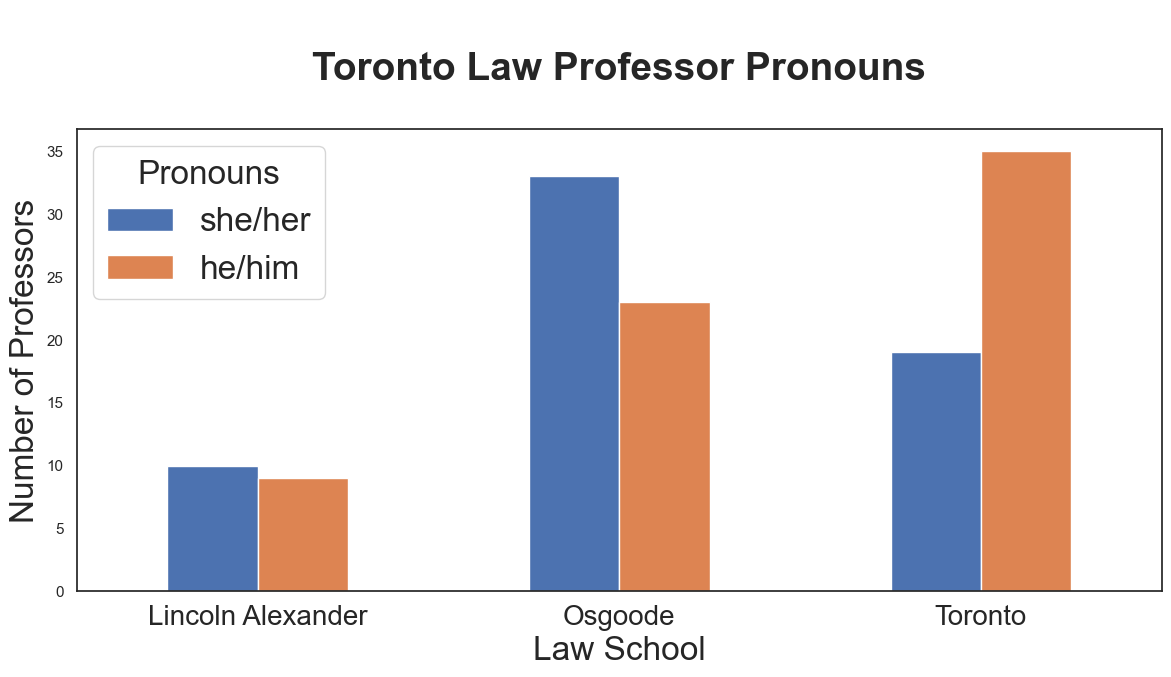

In [110]:
# modify the order of the columns in the DataFrame so that pronouns appear in same order as in the boxplots
df_pronouns = df_pronouns.pivot_table(index='university', columns='pronouns', aggfunc='size')
df_pronouns = df_pronouns[['she/her', 'he/him']]

# bar chart with the number of professors with each pronoun, broken down by university
sns.set_palette('husl')
sns.set_theme(style="white")
df_pronouns.plot(kind='bar', stacked=False)
plt.xlabel('Law School', fontsize=24)
plt.ylabel('Number of Professors', fontsize=24)
plt.xticks(rotation=0, ha='center', fontsize=20)
plt.gcf().set_size_inches(14, 6)
plt.title('\nToronto Law Professor Pronouns\n', fontweight='bold', fontsize=28)
plt.legend(title='Pronouns', fontsize=24, title_fontsize=24)
plt.show()

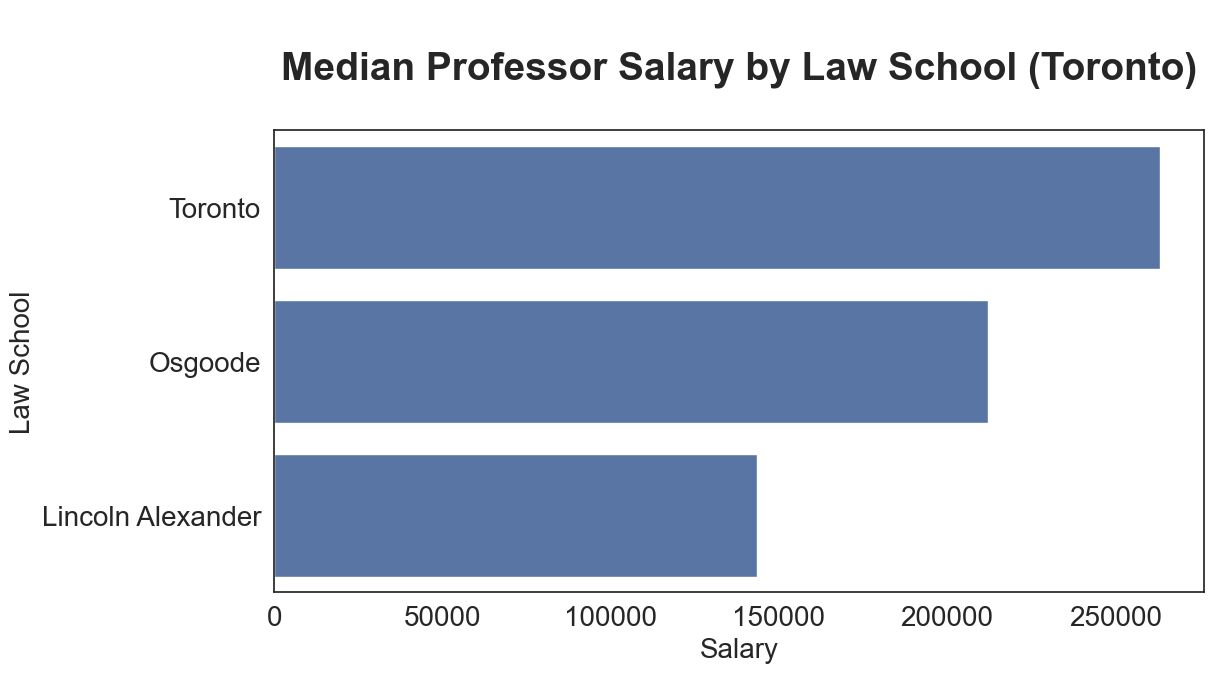

In [111]:
# Calculate the order based on median salaries
order = df_merged.groupby('university')['Salary'].median().sort_values(ascending=False).index

# Set the estimator to numpy.median
ax = sns.barplot(
    x="Salary", y="university", data=df_merged,
    order=order, estimator=np.median,  # Use numpy's median function here
    errorbar=None
)

# Setting the title, labels, and other aesthetic parameters
ax.set_title('\nMedian Professor Salary by Law School (Toronto)\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Salary', fontsize=20)
ax.set_ylabel('Law School', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(12, 6)
plt.show()

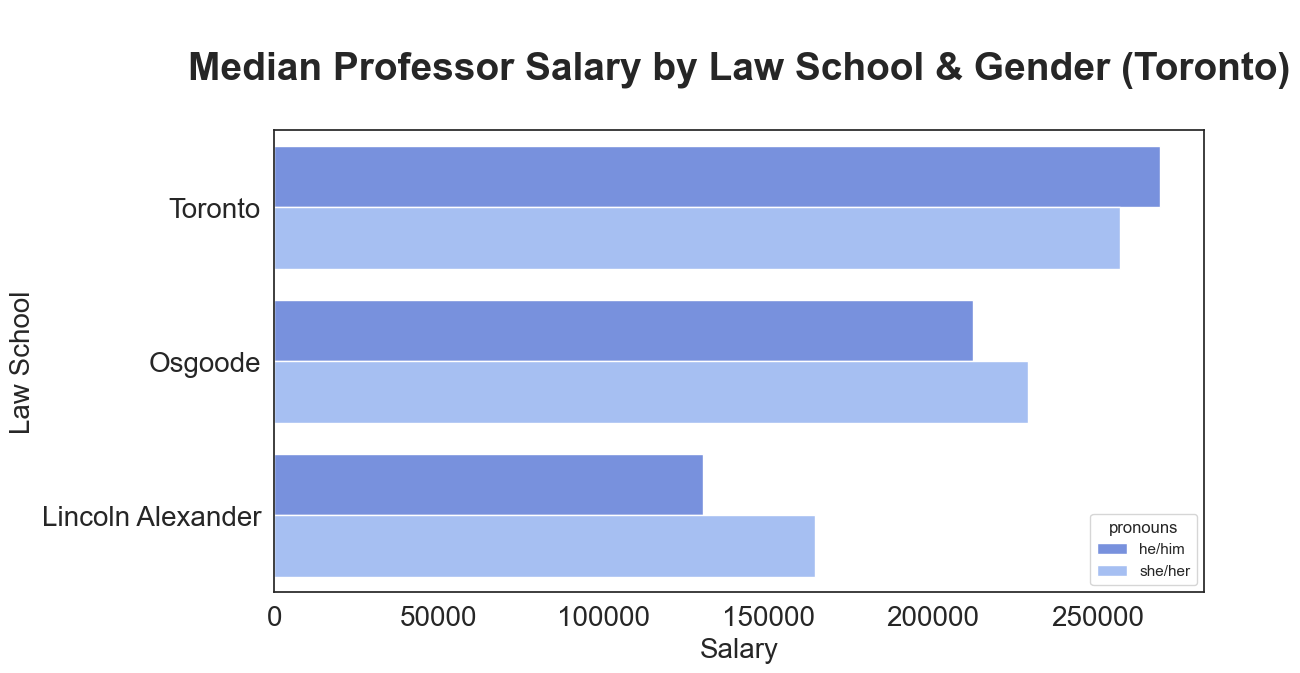

In [112]:
# groupby to get university and pronouns, then get the median salary for each group
df_pronouns = df_merged.copy()
df_grouped = df_pronouns.groupby(['university', 'pronouns'])['Salary'].median().reset_index()

# drop other pronouns
df_grouped = df_grouped[df_grouped['pronouns'] != 'other']

# Set the theme and palette
sns.set_theme(style="white")
sns.set_palette('coolwarm')

# Determine the order of the universities based on the overall median salary across all pronouns
order = df_grouped.groupby('university')['Salary'].median().sort_values(ascending=False).index

# Create the bar chart
ax = sns.barplot(
    x="Salary", y="university", hue="pronouns", data=df_grouped,
    order=order,  # Use the determined order
    errorbar=None
)

# Setting titles and labels
ax.set_title('\nMedian Professor Salary by Law School & Gender (Toronto)\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Salary', fontsize=20)
ax.set_ylabel('Law School', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# Adjust the size of the figure
plt.gcf().set_size_inches(12, 6)
plt.show()

### Individual Schools

In [113]:
df_merged[df_merged['university']== 'Osgoode'].sort_values('Salary', ascending=False)

,name,university,faculty,href,bio,extracted_research_areas,pronouns,Title,Salary
24,Steven Hoffman,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Dr. Steven J. Hoffman is the Dahdaleh Distingu...,"[Health Law, International Law, Disinformation...",he/him,Professor/Senior Advisor/Advisor/Endowed Chair,407023.12
40,Lisa Philipps,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Lisa Philipps teaches and writes abo...,"[Tax Law, Gender and the Law, Equality, Family...",she/her,Provost and Vice President Academic /Senior Ad...,376543.56
12,Mary G. Condon,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Mary Condon served as Dean of Osgoode Hall Law...,"[Feminist Legal Theory, Pensions, Securities]",she/her,Dean/Professor,353397.37
20,Trevor C. W. Farrow,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Trevor Farrow is Dean of Osgoode Hall Law Scho...,"[Access to Justice, Civil Procedure, Dispute R...",he/him,Dean/Associate Dean/Professor,307890.67
28,Jinyan Li,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Jinyan Li is Professor of Tax Law and former I...,"[Tax Law, E-commerce Law]",she/her,Professor/Part Time Instructor,300164.56
25,Allan C. Hutchinson,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,"A member of Osgoode’s faculty since 1982, Prof...","[Civil Procedure, Constitutional Law, Corporat...",he/him,Professor,295692.60
26,Shelley Kierstead,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Shelley Kierstead’s research interes...,"[Access to Justice, Dispute Resolution, Family...",she/her,Assistant Professor,288227.50
42,Poonam Puri,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Professor Poonam Puri is a nationally and inte...,"[Corporate Governance, Corporate Law, Financia...",she/her,Professor,287900.66
21,Benjamin Geva,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,Dr. Benjamin Geva is a Professor of Law at Osg...,"[Banking Law, Commercial Law, Comparative Law,...",he/him,Professor,286000.39
46,Craig M. Scott,Osgoode,osgoode,https://www.osgoode.yorku.ca/faculty-and-staff...,"As of July 2021, Professor Craig Scott is serv...","[Legal Theory, Public International Law, Priva...",he/him,Associate Dean/Professor,279428.98


In [114]:
df_merged[df_merged['university']== 'Lincoln Alexander'].sort_values('Salary', ascending=False)

,name,university,faculty,href,bio,extracted_research_areas,pronouns,Title,Salary
129,Donna Young,Lincoln Alexander,tmu,https://www.torontomu.ca/law/about/our-dean/,Donna E. Young is the Founding Dean of the Lin...,"[Academic Freedom, Anti-Discrimination, Civil ...",she/her,Dean Faculty of Law,339966.71
119,Avner Levin,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Avner Levin is a professor at Toronto Metropol...,"[Law and Technology, Privacy Law]",he/him,Professor,237919.55
116,Sari Graben,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Sari Graben’s teaching and research focuses on...,"[Aboriginal Law, Environmental Law, Gender and...",she/her,Associate Dean Research and Graduate Studies,230050.32
126,Timothy J. Bartkiw,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Timothy J. Bartkiw is an associate professor i...,"[Employment Law, Labour Law, Comparative Law]",he/him,Associate Professor,212942.60
128,Alexandra Orlova,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Alexandra Orlova received her PhD in law from ...,"[Criminal Law, International Criminal Law, Hum...",she/her,Professor,205203.97
127,Gil Lan,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Gil Lan is an associate professor in the Linco...,"[Comparative Law, Corporate Governance, Intern...",he/him,Associate Professor,201153.85
125,Pnina Alon-Shenker,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Pnina Alon-Shenker is an associate professor i...,"[Employment Law, Labour Law, Human Rights Law,...",she/her,Associate Professor,199005.46
111,Idil Atak,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Dr. Idil Atak is a professor at the Lincoln Al...,"[Human Rights Law, Immigration and Refugee Law...",she/her,Professor,171904.54
113,Hilary Evans Cameron,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,"A former litigator, Hilary Evans Cameron repre...","[Administrative Law, Clinical Legal Education,...",she/her,Assistant Professor,156372.76
115,Scott Franks,Lincoln Alexander,tmu,https://www.torontomu.ca/law/faculty-and-resea...,Scott Franks is an assistant professor in the ...,"[Aboriginal Law, Constitutional Law, Criminal ...",he/him,Assistant Professor,143487.88


In [115]:

df_merged[df_merged['university']== 'Toronto'].sort_values('Salary', ascending=False)

,name,university,faculty,href,bio,extracted_research_areas,pronouns,Title,Salary
68,Alexander Dyck,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor of Finance and Economic Analysis and...,"[Corporate Governance, Corporate Law, Corporat...",he/him,Professor of Finance,530666.66
92,Cheryl Regehr,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Vice-President and Provost Simcoe Hall 27 King...,"[Civil Litigation, Criminal Law, Health Law]",she/her,"Vice President and Provost; Professor, Factor-...",441154.94
93,Arthur Ripstein,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,"Professor of Law and Philosophy, University Pr...","[Legal Philosophy, Torts, Legal Theory, Politi...",he/him,Professor of Law and Philosophy,395554.50
69,David Dyzenhaus,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,University Professor of Law and Philosophy and...,"[Administrative Law, Comparative Law, Legal Th...",he/him,Professor of Law and Philosophy,391514.04
77,Edward Iacobucci,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor & TSE Chair in Capital Markets Jackm...,"[Competition Law, Corporate Law, Law and Econo...",he/him,Professor of Law,389531.00
63,Jutta Brunnée,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,"Dean, University Professor & James Marshall To...","[Climate Change, International Environmental L...",she/her,Dean and Professor of Law,386923.98
64,Brenda Cossman,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,"Professor of Law, Goodman-Schipper Chair and A...","[Family Law, Feminist Legal Theory, Gender and...",she/her,Professor of Law and Associate Dean Research,382884.90
75,Gillian Hadfield,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Schwartz Reisman Chair in Technology and Socie...,"[Artificial Intelligence, Contracts, Dispute R...",she/her,Professor of Law and Strategic Management,373582.94
80,Brian Langille,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor Jackman Law BuildingRoom J45478 Quee...,"[Charter of Rights and Freedoms, Contracts, In...",he/him,Professor of Law,373488.64
95,Kent Roach,Toronto,u_toronto,https://www.law.utoronto.ca/faculty-staff/full...,Professor Jackman Law BuildingRoom J446 78 Que...,"[Charter of Rights and Freedoms, Comparative L...",he/him,Professor of Law,371552.32


### Visualize Ontario

NOTE: Not currently working for U Ottawa, because of (a) missing bios and (b) french bios that get categorized as pronouns other.

CONSIDER: creating a new script to look for pronouns in the french bios, though that is more complicated and in some places requires inferences 

OR

Remove Ottawa Civil Law from the mix, and make this about common law schools in Ontario.



In [116]:
# Read merged data
df_merged = pd.read_json('data/ontario_bios_w_salaries.json')

In [117]:
# get average Salary for each university in df_merged
print ('Mean Salary by University')
print(df_merged.groupby('university')['Salary'].mean())
print()
print ('Median Salary by University')
print(df_merged.groupby('university')['Salary'].median())
print()
print ('-------------------------')
print()


def get_pronouns(text):

    if not text:
        return "other"

    # Create a dictionary to keep track of the count of each pronoun
    pronoun_count = {"he": 0, "him": 0, "his": 0, "she": 0, "her": 0, "hers": 0, "they": 0, "them": 0, "their": 0, "theirs": 0}

    # prepare the text for analysis
    text = text.lower().split()

    # count the pronouns
    for word in text:
        if word in pronoun_count:
            pronoun_count[word] += 1

    # if no pronouns, return "other"
    if sum(pronoun_count.values()) == 0:
        return "other"

    # Get the most common pronouns
    most_common_pronoun = max(pronoun_count, key=pronoun_count.get)
    if most_common_pronoun in ["he", "him", "his"]:
        return "he/him"
    elif most_common_pronoun in ["she", "her", "hers"]:
        return "she/her"
    else:
        return "they/them"

# get pronouns for each bio using apply
df_merged['pronouns'] = df_merged['bio'].apply(get_pronouns)

# fix two pronouns 
df_merged.loc[df_merged['name'] == 'Ravi Malhotra', 'pronouns'] = 'he/him'  # error caused by French, but pronouns used in en bio
df_merged.loc[df_merged['name'] == 'Michael Geist', 'pronouns'] = 'he/him' # error caused by French, but pronouns used in en bio
df_merged.loc[df_merged['name'] == 'Ellen Zweibel', 'pronouns'] = 'other' # first person

# NOT FIXED BECAUSE NO PRONOUNS AVAILABLE
# Saptarishi Bandopadhyay No pronouns used in bio
# Peter Cziraki No bio
# Patricia Peppin First person
# Ruth Kuras No bio
# Margaret Liddle No bio
# Lisa Trabucco No bio
# Jula Hughes No pronouns used in bio
# Amir Attaran No pronouns used in bio
# Jeremy De Beer first person
# Sylvia Rich first person
# Penelope Simons first person
# LIST DOES NOT INCLUDE OTTAWA CIVIL LAW

# create new df with only pronouns and salary, and print value counts
df_pronouns = df_merged.copy()
print ('Pronouns used in bios')
print(df_pronouns.value_counts('pronouns'))
print()
print ('-------------------------')
print()

# Remove 'other' because this means no pronouns used in bio (e.g. first person or bio missing)
df_pronouns = df_pronouns[df_pronouns['pronouns'] != 'other']

# Note: No they/them pronouns used in any bios

# get mean and median salary for each pronoun
print('Mean Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].mean())
print()
print ('Median Salary by Pronouns')
print(df_pronouns.groupby('pronouns')['Salary'].median())
print()
print ('-------------------------')
print()

# get median salary for each pronoun, per university 
print('Mean Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].mean())
print()
print('Median Salary by Pronouns and University')
print(df_pronouns.groupby(['university', 'pronouns'])['Salary'].median())



Mean Salary by University
university
Lakehead             138662.443636
Lincoln Alexander    173324.840526
Osgoode              216569.878947
Ottawa               177552.454776
Queens               204710.118000
Toronto              275472.058704
Western              164992.552000
Windsor              159711.192143
Name: Salary, dtype: float64

Median Salary by University
university
Lakehead             129381.12
Lincoln Alexander    143487.88
Osgoode              212241.60
Ottawa               171349.68
Queens               201818.22
Toronto              263314.47
Western              154518.66
Windsor              153552.32
Name: Salary, dtype: float64

-------------------------

Pronouns used in bios
pronouns
he/him     155
she/her    139
other       12
Name: count, dtype: int64

-------------------------

Mean Salary by Pronouns
pronouns
he/him     206941.814129
she/her    196797.163885
Name: Salary, dtype: float64

Median Salary by Pronouns
pronouns
he/him     196518.92
she/her   

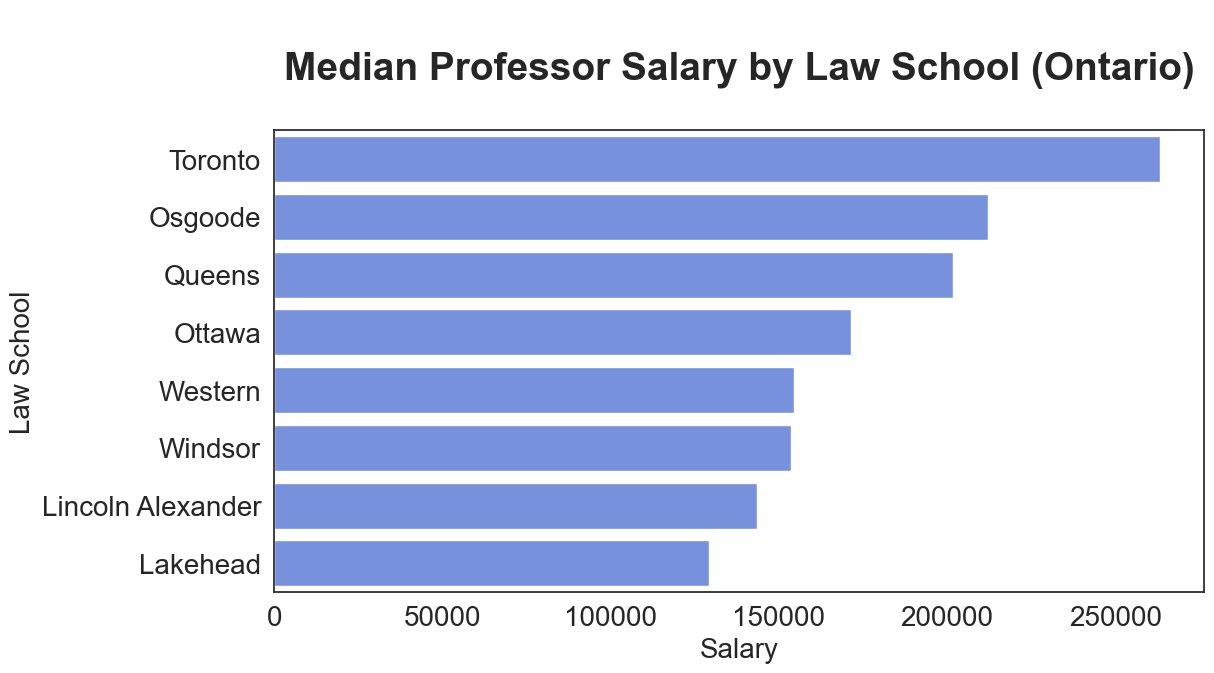

In [118]:

# Calculate the order based on median salaries
order = df_merged.groupby('university')['Salary'].median().sort_values(ascending=False).index

# Set the estimator to numpy.median
ax = sns.barplot(
    x="Salary", y="university", data=df_merged,
    order=order, estimator=np.median,  # Use numpy's median function here
    errorbar=None
)

# Setting the title, labels, and other aesthetic parameters
ax.set_title('\nMedian Professor Salary by Law School (Ontario)\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Salary', fontsize=20)
ax.set_ylabel('Law School', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.gcf().set_size_inches(12, 6)
plt.show()

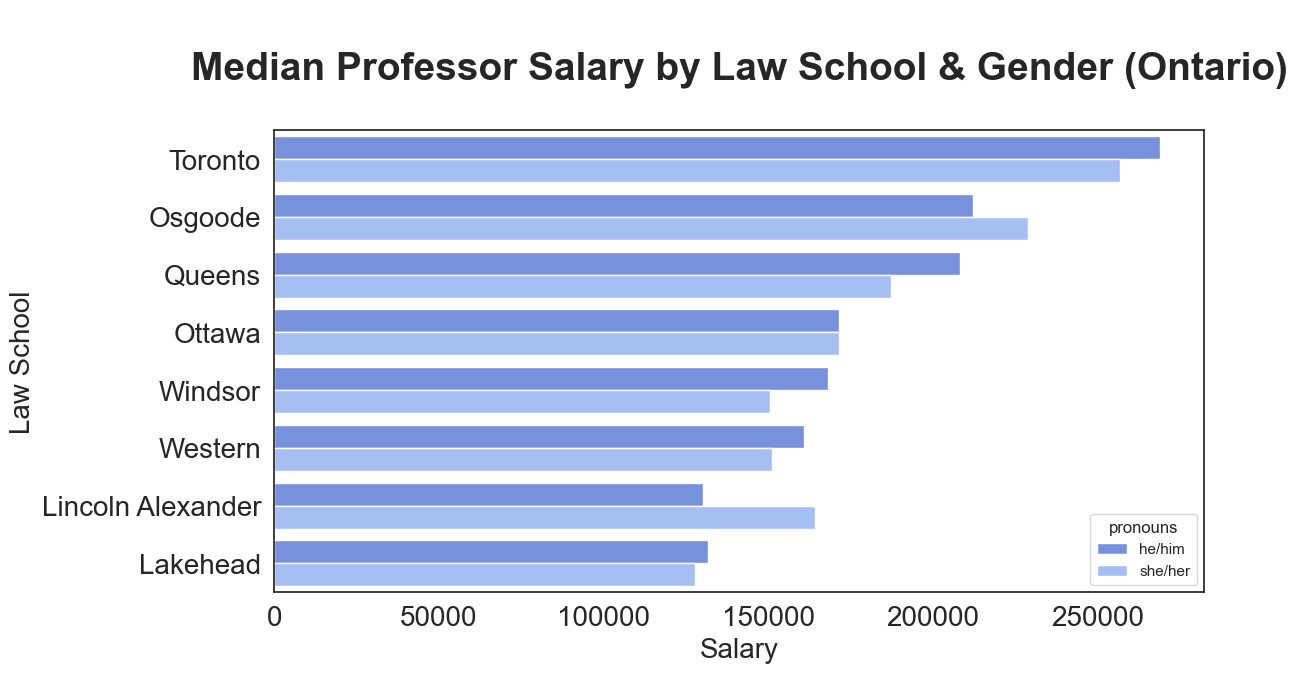

In [119]:
# groupby to get university and pronouns, then get the median salary for each group
df_grouped = df_pronouns.groupby(['university', 'pronouns'])['Salary'].median().reset_index()
#df_grouped

# Set the theme and palette
sns.set_theme(style="white")
sns.set_palette('coolwarm')

# Determine the order of the universities based on the overall median salary across all pronouns
order = df_grouped.groupby('university')['Salary'].median().sort_values(ascending=False).index

# Create the bar chart
ax = sns.barplot(
    x="Salary", y="university", hue="pronouns", data=df_grouped,
    order=order,  # Use the determined order
    errorbar=None
)

# Setting titles and labels
ax.set_title('\nMedian Professor Salary by Law School & Gender (Ontario)\n', fontweight='bold', fontsize=28)
ax.set_xlabel('Salary', fontsize=20)
ax.set_ylabel('Law School', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# Adjust the size of the figure
plt.gcf().set_size_inches(12, 6)
plt.show()

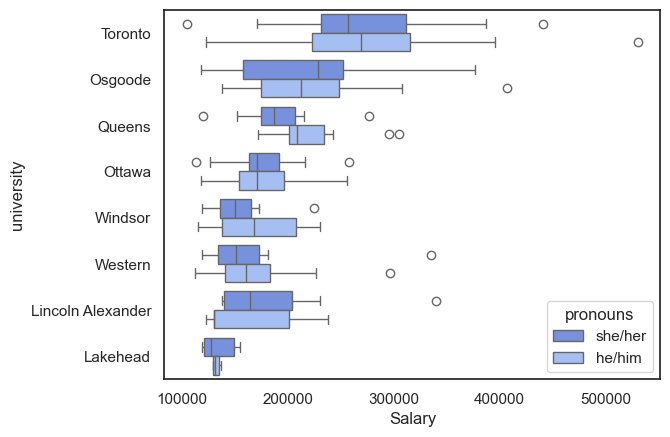

In [120]:
# Box plot of salary by university and pronouns, with univesrity as y axis
sns.set_theme(style="white")
sns.set_palette('coolwarm')
ax = sns.boxplot(x="Salary", y="university", hue="pronouns", data=df_pronouns, order=df_pronouns.groupby('university')['Salary'].median().sort_values(ascending=False).index)


Text(0.5, 1.0, '\nMedian Law Professor Salary by Gender (Ontario)\n')

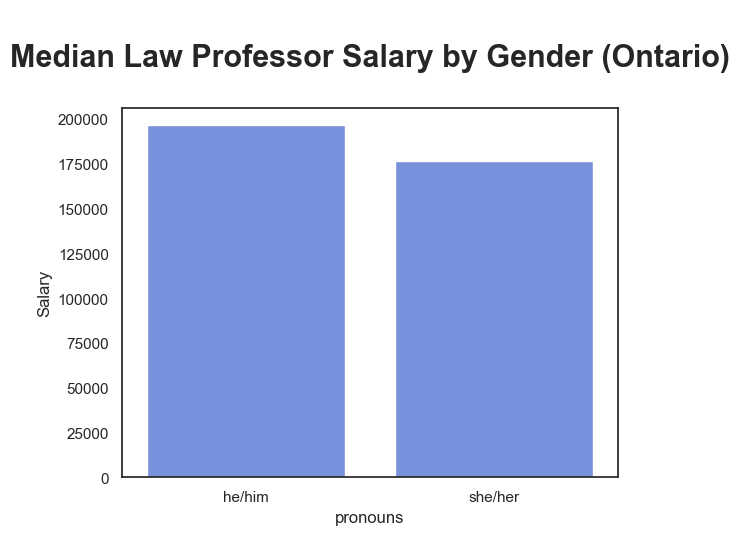

In [121]:
groupby = df_pronouns.groupby('pronouns')['Salary'].median().sort_values(ascending=False).reset_index()

# bar chart based on groupby, with pronouns as x asis
sns.set_theme(style="white")
sns.set_palette('coolwarm')
ax = sns.barplot(x="pronouns", y="Salary", data=groupby, errorbar=None)

ax.set_title('\nMedian Law Professor Salary by Gender (Ontario)\n', fontweight='bold', fontsize=22)


### Salaries and research expertise

In [122]:
# Read merged data
df_merged = pd.read_json('data/ontario_bios_w_salaries.json')

# Exclude Ottawa Civil Law
df_merged = df_merged[df_merged['university'] != 'Ottawa Civil Law']

# get median salary for each item in list in df_merged.extracted_research_areas (handling none values)

df_expanded = df_merged.explode('extracted_research_areas')

# Calculate the median and count for each group
grouped_data = df_expanded.groupby('extracted_research_areas')['Salary'].agg(['mean', 'count']).reset_index()

# Sort the results by the median salary
sorted_data = grouped_data.sort_values(by='mean', ascending=False).reset_index(drop=True)

#reformat
sorted_data['mean'] = sorted_data['mean'].map('${:,.0f}'.format)
sorted_data = sorted_data.rename(columns={'mean': 'AVERAGE SALARY'})
sorted_data = sorted_data.rename(columns={'extracted_research_areas': 'RESEARCH AREA'})
sorted_data = sorted_data.rename(columns={'count': 'COUNT'})

# add title: Average law faculty salary by research area (Ontario)
print( 'Average law faculty salary in 2023 by research area in Ontario \n (common law faculties) (research areas with 20+ faculty)\n')

# print sorted data filtering to include only count > 15, hide index
print(sorted_data[sorted_data['COUNT'] >= 15].to_string(index=False))




Average law faculty salary in 2023 by research area in Ontario 
 (common law faculties) (research areas with 20+ faculty)

                 RESEARCH AREA AVERAGE SALARY  COUNT
          Political Philosophy       $240,193     15
                  Legal Theory       $235,881     47
Charter of Rights and Freedoms       $235,306     15
                 Corporate Law       $225,176     21
       Artificial Intelligence       $211,528     18
                    Family Law       $210,070     21
             International Law       $209,472     32
                      Equality       $207,473     20
                         Torts       $207,166     35
               Comparative Law       $205,999     38
         Intellectual Property       $205,207     25
                    Health Law       $204,880     19
            Gender and the Law       $203,861     23
         Feminist Legal Theory       $203,427     31
                  Legal Ethics       $201,758     18
                   Privacy La